#### Import Packages and Data from CSV File

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# read in the turnount data

turnout = pd.read_csv('Turnout_study_2013-23.csv', index_col=0)

# turnout.info()

C:\Users\nlofl\AppData\Local\Temp\ipykernel_31704\1533067849.py:10: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  turnout = pd.read_csv('Turnout_study_2013-23.csv', index_col=0)


#### Data Cleaning

In [49]:
# only engines and ladders
turnout = turnout[turnout['fwx_unit_id'].str.startswith(('E', 'L'))]

# only calls where units were not canceled
turnout = turnout[turnout['fwx_unit_canceled'] != 1]

# only calls after AVL turnout was implemented
turnout = turnout[turnout['fwx_unit_year'] >= 2015]

# only calls where turnout was greater than 10 seconds (no rolling starts considered)
turnout_clean = turnout[turnout['fwx_unit_turnout'] > 10]

# only engines and ladders
turnout_clean_7 = turnout_clean[turnout_clean['fwx_unit_id'].isin(['L7', 'E7'])]


#### Assign Categorical Variables for Station Type, Night Response, and Dispatch Type

In [50]:
turnout_clean = turnout_clean[['fwx_unit_dispatch_type','fwx_unit_incident_type','fwx_unit_turnout','fwx_unit_canceled','fwx_unit_hour','station_const_era']]

# Create variable for station construction era

turnout_clean['1950'] = turnout_clean['station_const_era'].apply(lambda x: 1 if x == 1950 else 0)
turnout_clean['1990'] = turnout_clean['station_const_era'].apply(lambda x: 1 if x == 1990 else 0)
turnout_clean['2000'] = turnout_clean['station_const_era'].apply(lambda x: 1 if x == 2000 else 0)
turnout_clean['2010'] = turnout_clean['station_const_era'].apply(lambda x: 1 if x == 2010 else 0)
turnout_clean['2020'] = turnout_clean['station_const_era'].apply(lambda x: 1 if x == 2020 else 0)

# Create variable for night response (10pm-6am)

turnout_clean['night'] = turnout_clean['fwx_unit_hour'].apply(lambda x: 1 if (x >=22 or x<=6) else 0)

# Create variables for dispatch type

turnout_clean['CARDIAC'] = turnout_clean['fwx_unit_dispatch_type'].apply(lambda x: 1 if x == 'CARDIA' else 0)
turnout_clean['STRUC'] = turnout_clean['fwx_unit_dispatch_type'].apply(lambda x: 1 if x == 'STRUC' else 0)
turnout_clean['OVERDOSE'] = turnout_clean['fwx_unit_dispatch_type'].apply(lambda x: 1 if x == 'OVDOSE' else 0)
turnout_clean['STAB'] = turnout_clean['fwx_unit_dispatch_type'].apply(lambda x: 1 if x == 'STAB' else 0)
turnout_clean['PIN-IN'] = turnout_clean['fwx_unit_dispatch_type'].apply(lambda x: 1 if x == '50PIN' else 0)





#### Create Multivariate Regression Model

In [51]:
independent=turnout_clean[['night','1950','1990','2000','2010','2020','CARDIAC','STRUC','OVERDOSE','STAB','PIN-IN']]
dependent=turnout_clean[['fwx_unit_turnout']]

independent = sm.add_constant(independent)

model = sm.OLS(dependent, independent).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:       fwx_unit_turnout   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     8375.
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:58:22   Log-Likelihood:            -1.7052e+06
No. Observations:              354393   AIC:                         3.410e+06
Df Residuals:                  354381   BIC:                         3.411e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.3680      0.276    330.914      0.0

#### Impact of Construction on Station 7 Turnout Times

In [66]:
turnout_clean_7['month-year']=turnout_clean_7['fwx_unit_month'].astype(str) + '-' + turnout_clean_7['fwx_unit_year'].astype(str)
turnout_clean_7['month-year']=pd.to_datetime(turnout_clean_7['month-year'], format='%m-%Y')

monthly_7 = turnout_clean_7.groupby(['month-year','fwx_unit_id']).agg({'fwx_unit_turnout':'median'}).reset_index()

#### Graph of Station 7 Turnout Times

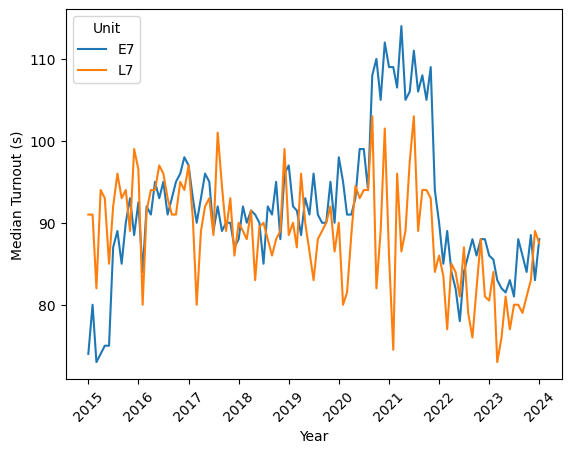

In [72]:
sns.lineplot(data=monthly_7, x='month-year', y='fwx_unit_turnout', hue='fwx_unit_id')
plt.xticks(rotation=45)
plt.ylabel('Median Turnout (s)')
plt.xlabel('Year')
plt.legend(loc='upper left', title='Unit')
plt.show()
